In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [40]:
# Load the full MNIST dataset
full_trainset = datasets.MNIST('full_trainset', download=True, train=True, transform=transform)

# Split the full_trainset into trainset, valset, and testset
train_size = int(0.8 * len(full_trainset))
val_size = int(0.1 * len(full_trainset))
test_size = len(full_trainset) - (train_size + val_size)

trainset, valset, testset = torch.utils.data.random_split(full_trainset, [train_size, val_size, test_size])

# Create data loaders for trainset, valset, and testset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)  # No need to shuffle validation set
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [4]:
dataiter = iter(trainloader)
images, labels  = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


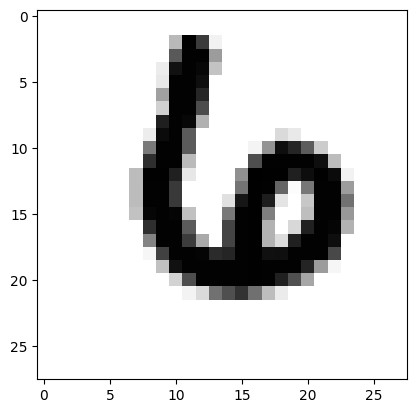

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

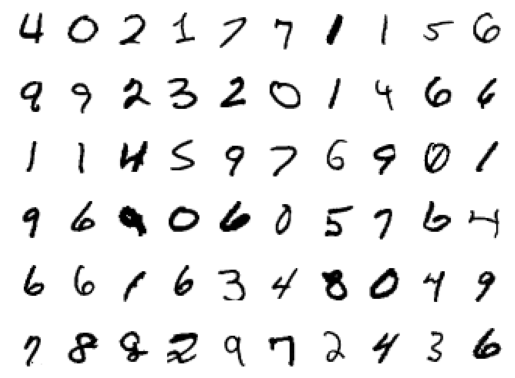

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0030,  0.0030,  0.0030,  ...,  0.0030,  0.0030,  0.0030],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        ...,
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002]])


In [44]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Initialize lists to store metrics
losses = []
accuracies = []
val_losses = []
val_accuracies = []

time0 = time()
epochs = 15

for e in range(epochs):
    running_loss = 0
    correct_count = 0
    
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy for this batch
        _, predicted = torch.max(output.data, 1)
        correct_count += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy for this epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = correct_count / len(trainloader.dataset)
    
    # Append loss and accuracy to lists
    losses.append(avg_loss)
    accuracies.append(accuracy)
    
    # Print epoch results for training
    print(f"Epoch {e+1}/{epochs} - Training loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.4f}")
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    
    val_loss = 0
    val_correct_count = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            val_loss += criterion(output, labels).item()
            
            # Calculate accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            val_correct_count += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = val_correct_count / len(valloader.dataset)
    
    # Append validation metrics to lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch results for validation
    print(f"Epoch {e+1}/{epochs} - Validation loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/15 - Training loss: 0.0118, Training Accuracy: 0.9972
Epoch 1/15 - Validation loss: 0.0579, Validation Accuracy: 0.9818
Epoch 2/15 - Training loss: 0.0107, Training Accuracy: 0.9980
Epoch 2/15 - Validation loss: 0.0473, Validation Accuracy: 0.9858
Epoch 3/15 - Training loss: 0.0102, Training Accuracy: 0.9982
Epoch 3/15 - Validation loss: 0.0484, Validation Accuracy: 0.9860
Epoch 4/15 - Training loss: 0.0096, Training Accuracy: 0.9983
Epoch 4/15 - Validation loss: 0.0536, Validation Accuracy: 0.9850
Epoch 5/15 - Training loss: 0.0085, Training Accuracy: 0.9986
Epoch 5/15 - Validation loss: 0.0563, Validation Accuracy: 0.9835
Epoch 6/15 - Training loss: 0.0085, Training Accuracy: 0.9985
Epoch 6/15 - Validation loss: 0.0462, Validation Accuracy: 0.9867
Epoch 7/15 - Training loss: 0.0071, Training Accuracy: 0.9991
Epoch 7/15 - Validation loss: 0.0488, Validation Accuracy: 0.9863
Epoch 8/15 - Training loss: 0.0070, Training Accuracy: 0.9990
Epoch 8/15 - Validation loss: 0.0480, Vali

In [45]:
torch.save(model, './my_mnist_model.pt') 

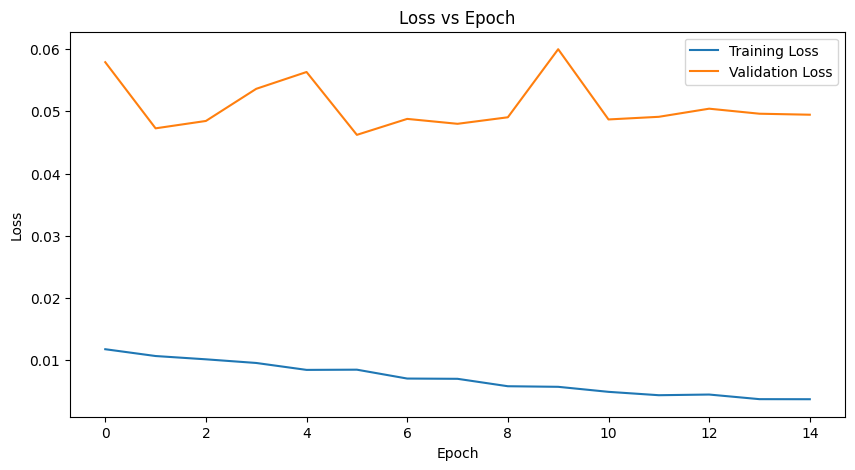

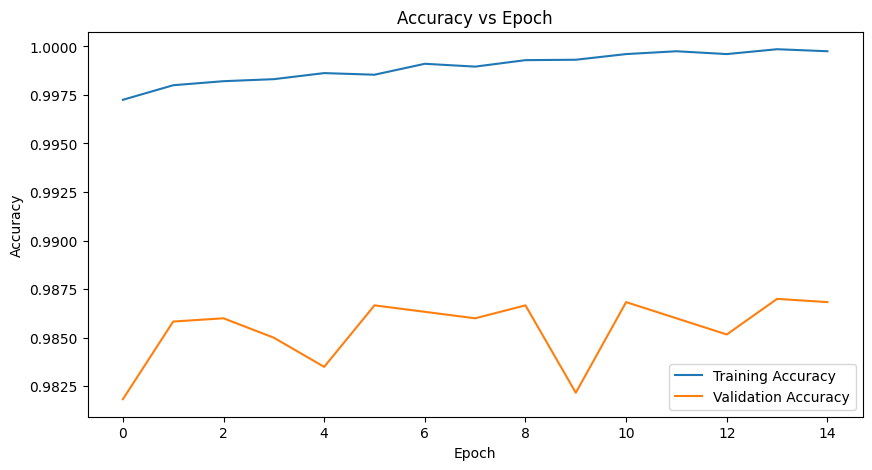

In [46]:
# Plot loss vs epoch for both training and validation
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy vs epoch for both training and validation
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [13]:

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [14]:
model = torch.load('D:\PESU IO\my_mnist_model.pt')
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

Predicted Digit = 4


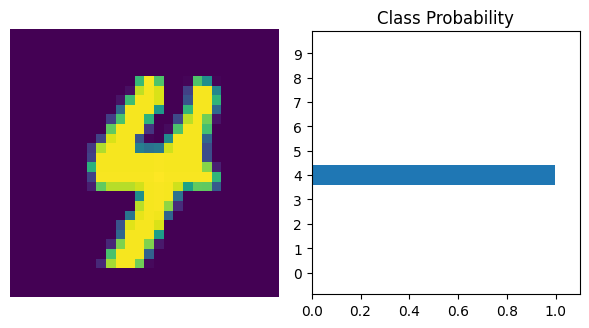

In [25]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [16]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9756


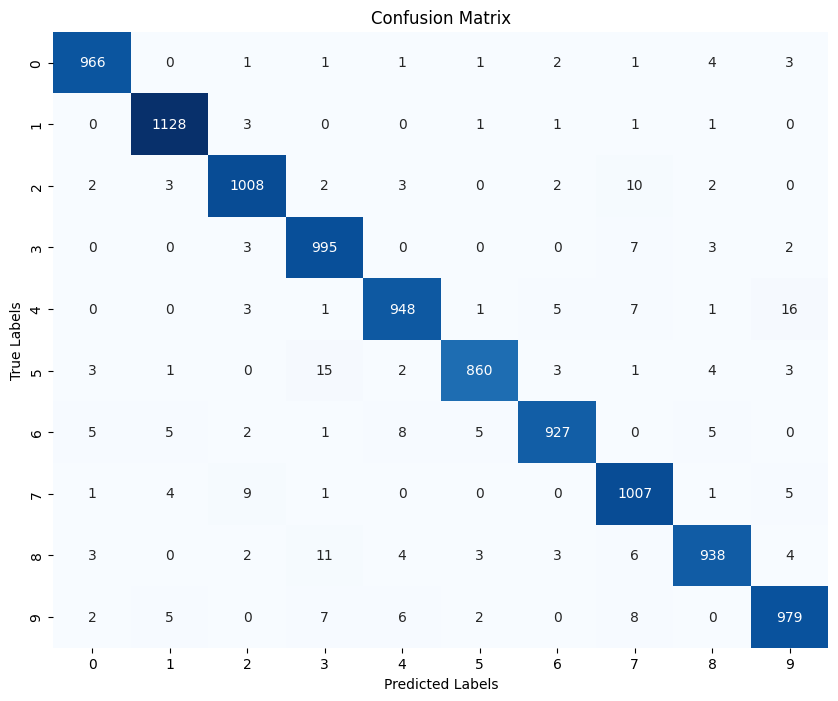

Class 0:
True Positives: 966,
True Negatives: 9004,
False Positives: 16,
False Negatives: 14

Class 1:
True Positives: 1128,
True Negatives: 8847,
False Positives: 18,
False Negatives: 7

Class 2:
True Positives: 1008,
True Negatives: 8945,
False Positives: 23,
False Negatives: 24

Class 3:
True Positives: 995,
True Negatives: 8951,
False Positives: 39,
False Negatives: 15

Class 4:
True Positives: 948,
True Negatives: 8994,
False Positives: 24,
False Negatives: 34

Class 5:
True Positives: 860,
True Negatives: 9095,
False Positives: 13,
False Negatives: 32

Class 6:
True Positives: 927,
True Negatives: 9026,
False Positives: 16,
False Negatives: 31

Class 7:
True Positives: 1007,
True Negatives: 8931,
False Positives: 41,
False Negatives: 21

Class 8:
True Positives: 938,
True Negatives: 9005,
False Positives: 21,
False Negatives: 36

Class 9:
True Positives: 979,
True Negatives: 8958,
False Positives: 33,
False Negatives: 30



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the validation data loader
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)
        
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        
        true_labels.append(true_label)
        pred_labels.append(pred_label)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print true positives, true negatives, false positives, false negatives for each class
for i in range(10):  # Assuming 10 classes
    tp = conf_matrix[i, i]
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp
    print(f"Class {i}:")
    print(f"True Positives: {tp},\nTrue Negatives: {tn},\nFalse Positives: {fp},\nFalse Negatives: {fn}")
    print()



In [18]:
# Print the classification report
target_names = [str(i) for i in range(10)]
print(classification_report(true_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.99      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.96      0.98      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Predicted Digit = 3
Predicted Digit = 9
Predicted Digit = 4


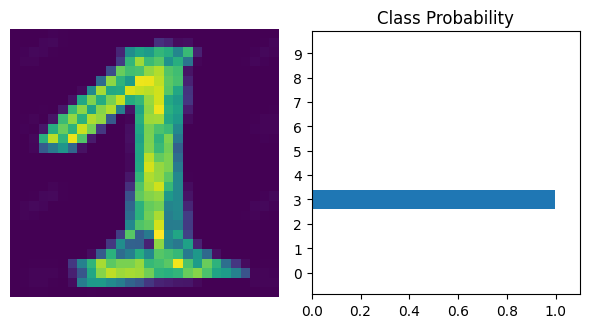

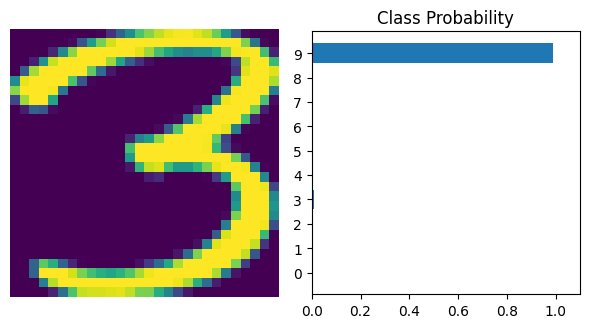

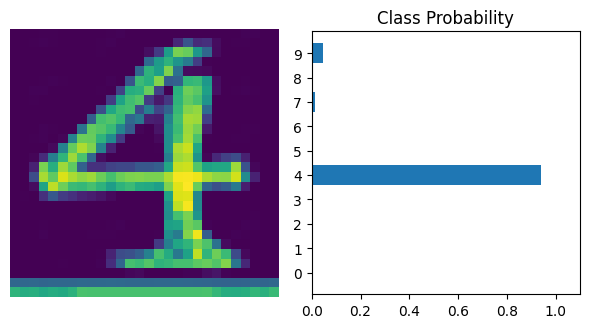

In [36]:
from PIL import Image, ImageOps
import os

def preprocess_user_image(image_path):
    user_image = Image.open(image_path).convert("L")
    user_image = user_image.resize((28, 28))
    user_image = ImageOps.invert(user_image)
    user_image = transform(user_image).view(1, 784)
    return user_image

# Get the path to the user's image

for image in os.listdir('D:\PESU IO\handwritten_digits_web'):
    user_image_path = "D:\PESU IO\handwritten_digits_web/"+image  # Replace with the actual path

    # Preprocess the user's image
    user_input = preprocess_user_image(user_image_path)

    # Use the trained model to make a prediction
    with torch.no_grad():
        logps = model(user_input)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])

    predicted_digit = probab.index(max(probab))
    print("Predicted Digit =", predicted_digit)
    view_classify(user_input.view(1, 28, 28), ps)
